In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

pd.options.display.max_rows = 10
nifty50 = pd.read_csv('https://www1.nseindia.com/content/indices/ind_nifty50list.csv')

In [2]:
tickers = [x + '.NS' for x in list(nifty50['Symbol'])]

In [3]:
nifty50 = list()
from pandas_datareader import data

# Only get the adjusted close.
nifty = data.DataReader(tickers, 
                       start='2016-1-1', 
                       end='2020-04-27', 
                       data_source='yahoo')['Adj Close']


In [4]:
# Convert the adjusted closing prices to cumulative returns.
# returns = aapl.pct_change()


NSEI = data.DataReader('^NSEI', 
                       start='2016-1-1', 
                       end='2020-04-27', 
                       data_source='yahoo')['Adj Close']

In [5]:
NSEI = NSEI.reset_index()

In [6]:
NSEI['Date'] = NSEI['Date'].dt.strftime('%Y-%m-%d')

In [10]:
NSEI['Return']=NSEI['Adj Close'].pct_change()
NSEI = NSEI.dropna()
NSEI

,Date,Adj Close,Return
1,2016-01-05,7784.649902,-0.000854
2,2016-01-06,7741.000000,-0.005607
3,2016-01-07,7568.299805,-0.022310
4,2016-01-08,7601.350098,0.004367
5,2016-01-11,7563.850098,-0.004933
...,...,...,...
1051,2020-04-21,8981.450195,-0.030275
1052,2020-04-22,9187.299805,0.022919
1053,2020-04-23,9313.900391,0.013780
1054,2020-04-24,9154.400391,-0.017125


In [15]:
NSEI_roll_std = NSEI['Return'].rolling(22).std()

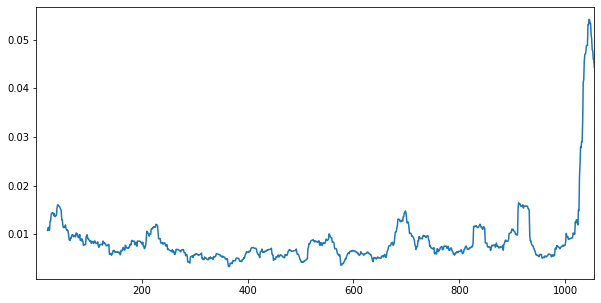

In [16]:
NSEI_roll_std.plot(figsize=(10,5))

In [20]:
nifty_ret = nifty.pct_change().dropna()

In [21]:
nifty_cor = nifty_ret.rolling(22).corr().dropna()
nifty_cor = nifty_cor.reset_index()

In [22]:
nifty_cor['Date'] = nifty_cor['Date'].dt.strftime('%Y-%m-%d')
# nifty_cor['Date'] = pd.to_datetime(nifty_cor['Date'])

In [73]:
long_corr = pd.melt(nifty_cor, id_vars=['Date','Symbols'], var_name='Stocks', value_name='Correlation')

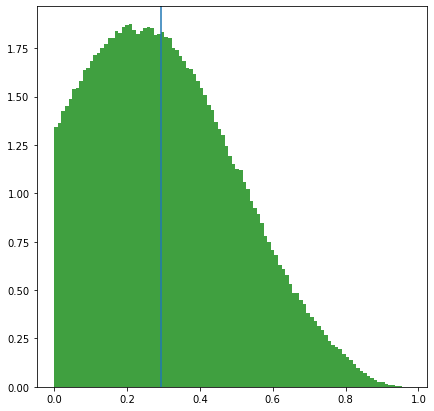

In [91]:
x = long_corr['Correlation'][long_corr['Correlation'] >= 0][long_corr['Correlation'] < 0.999999]
cutoff_pos = x.quantile()
plt.figure(figsize = (7,7))
plt.axvline(x.quantile())
n, bins, patches = plt.hist(x, 100, density=True, facecolor='g', alpha=0.75)

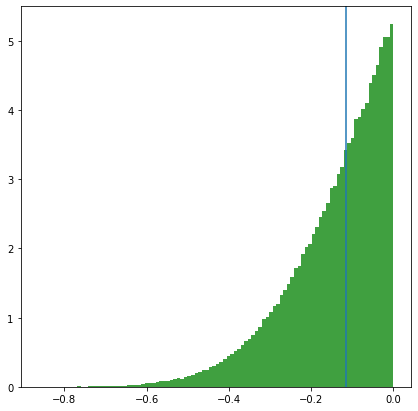

In [92]:
x = long_corr['Correlation'][long_corr['Correlation'] < 0]
cutoff_neg = x.quantile()
plt.figure(figsize = (7,7))
plt.axvline(x.quantile())
n, bins, patches = plt.hist(x, 100, density=True, facecolor='g', alpha=0.75)

In [97]:
def get_graph(df_subset, cutoff_pos, cutoff_neg):
    adj = df_subset.applymap(lambda x: x if ((x <= cutoff_neg or x >= cutoff_pos) and x != 1) else 0).to_numpy()
    adj_pos = df_subset.applymap(lambda x: x if ((x >= cutoff_pos) and x != 1) else 0).to_numpy()
    g = nx.from_numpy_matrix(adj, parallel_edges=False)
    g_pos = nx.from_numpy_matrix(adj_pos, parallel_edges=False)
    return g, g_pos

In [128]:
G = {}
G_pos = {}
graph_metrics = pd.DataFrame(columns = ['Date','Positive Edge Ratio','Clustering','Positive Clustering'])

for date in list(nifty_cor['Date'].unique()):
    graph_df = nifty_cor[nifty_cor['Date']==date].drop(['Date','Symbols'], axis=1)
    G[date], G_pos[date] = get_graph(graph_df, cutoff_pos, cutoff_neg)
    edge_ratio = len(G_pos[date].edges)/len(G[date].edges)
    temp = nx.average_clustering(G[date], weight = 'weight')
    temp_pos = nx.average_clustering(G_pos[date], weight = 'weight')
    graph_metrics_coef = pd.DataFrame({'Date': [date],
                                        'Positive Edge Ratio' : [edge_ratio],
                                        'Clustering': [temp],
                                        'Positive Clustering' : [temp_pos]})
    graph_metrics = pd.concat([graph_metrics,graph_metrics_coef], sort=False)
    print(len(graph_metrics)*100/len(list(nifty_cor['Date'].unique())),end='\r')


In [129]:
graph_metrics['Absolute Clustering'] =  graph_metrics['Clustering'].abs()

In [130]:
graph_metrics = graph_metrics.reset_index()

In [131]:
graph_metrics = pd.merge(graph_metrics, NSEI, on = 'Date')

In [132]:
graph_metrics['Std Deviation'] = graph_metrics['Return'].rolling(22).std()

In [139]:
VIX = pd.read_csv('NIFTYVIX.csv')
VIX['Date'] = pd.to_datetime(VIX['Date'], format='%d-%m-%Y')
graph_metrics['Date'] = pd.to_datetime(graph_metrics['Date'], '')
graph_metrics = pd.merge(graph_metrics, VIX, on = 'Date', how='left')

In [140]:
graph_metrics

,index,Date,Positive Edge Ratio,Clustering,Positive Clustering,Absolute Clustering,Adj Close,Return,Std Deviation,NIFTYVIX
0,0,2016-02-03,0.962141,(0.33304954857465546+0.004999228378300175j),0.358019,0.333087,7361.799805,-0.012575,NaN,18.5875
1,0,2016-02-04,0.958777,(0.32388304077236396+0.005045596106762806j),0.347303,0.323922,7404.000000,0.005732,NaN,18.2075
2,0,2016-02-05,0.964149,(0.33348921371514634+0.005573174888031848j),0.356603,0.333536,7489.100098,0.011494,NaN,18.1150
3,0,2016-02-08,0.963338,(0.34561484548450644+0.005400123441928579j),0.367475,0.345657,7387.250000,-0.013600,NaN,20.2575
4,0,2016-02-09,0.943166,(0.3045411531398577+0.008725964747775764j),0.335253,0.304666,7298.200195,-0.012055,NaN,21.7275
...,...,...,...,...,...,...,...,...,...,...
1030,0,2020-04-21,0.999167,(0.5674151115212323+0.0006405403158138498j),0.568123,0.567415,8981.450195,-0.030275,0.047833,45.1975
1031,0,2020-04-22,0.999165,(0.5679873341930256+0.0005680812680761387j),0.568692,0.567988,9187.299805,0.022919,0.047728,42.8225
1032,0,2020-04-23,1.000000,0.565756,0.565756,0.565756,9313.900391,0.013780,0.045989,39.2300
1033,0,2020-04-24,1.000000,0.570337,0.570337,0.570337,9154.400391,-0.017125,0.045795,39.1175


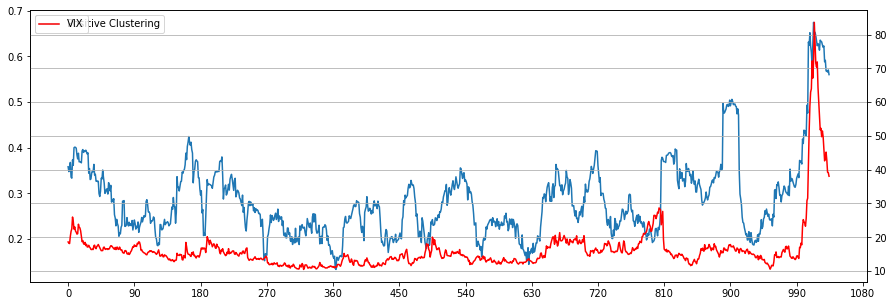

In [145]:
fig, ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()

#ax.plot(graph_metrics['Absolute Clustering'], label='Absolute Clustering')
ax.plot(graph_metrics['Positive Clustering'], label='Positive Clustering')
#ax.plot(graph_metrics['Positive Edge Ratio'], label='Positive Edge Ratio')


ax2.plot(graph_metrics['NIFTYVIX'], label='VIX', color='r')
ax.legend()
ax2.legend()
loc = plticker.MultipleLocator(base= 90) # this locator puts ticks at regular intervals

ax.xaxis.set_major_locator(loc)

plt.grid(True)
plt.show()

In [148]:
graph_metrics

,index,Date,Positive Edge Ratio,Clustering,Positive Clustering,Absolute Clustering,Adj Close,Return,Std Deviation,NIFTYVIX
0,0,2016-02-03,0.962141,(0.33304954857465546+0.004999228378300175j),0.358019,0.333087,7361.799805,-0.012575,NaN,18.5875
1,0,2016-02-04,0.958777,(0.32388304077236396+0.005045596106762806j),0.347303,0.323922,7404.000000,0.005732,NaN,18.2075
2,0,2016-02-05,0.964149,(0.33348921371514634+0.005573174888031848j),0.356603,0.333536,7489.100098,0.011494,NaN,18.1150
3,0,2016-02-08,0.963338,(0.34561484548450644+0.005400123441928579j),0.367475,0.345657,7387.250000,-0.013600,NaN,20.2575
4,0,2016-02-09,0.943166,(0.3045411531398577+0.008725964747775764j),0.335253,0.304666,7298.200195,-0.012055,NaN,21.7275
...,...,...,...,...,...,...,...,...,...,...
1030,0,2020-04-21,0.999167,(0.5674151115212323+0.0006405403158138498j),0.568123,0.567415,8981.450195,-0.030275,0.047833,45.1975
1031,0,2020-04-22,0.999165,(0.5679873341930256+0.0005680812680761387j),0.568692,0.567988,9187.299805,0.022919,0.047728,42.8225
1032,0,2020-04-23,1.000000,0.565756,0.565756,0.565756,9313.900391,0.013780,0.045989,39.2300
1033,0,2020-04-24,1.000000,0.570337,0.570337,0.570337,9154.400391,-0.017125,0.045795,39.1175


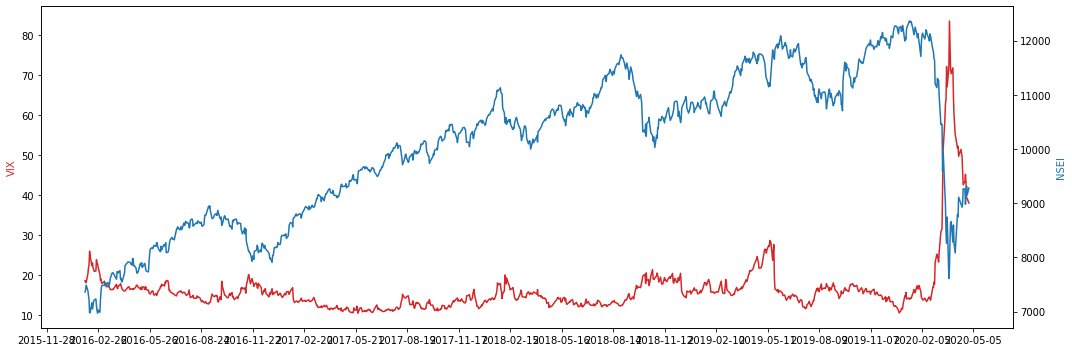

In [149]:
fig, ax1 = plt.subplots(figsize=(15,5))

color = 'tab:red'
# ax1.set_xlabel('time (s)')
ax1.set_ylabel('VIX', color=color)
ax1.plot(graph_metrics['Date'], graph_metrics['NIFTYVIX'], color=color)
# ax1.tick_params(axis='y', labelcolor=color)
loc = plticker.MultipleLocator(base= 90) # this locator puts ticks at regular intervals

ax1.xaxis.set_major_locator(loc)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('NSEI', color=color)  # we already handled the x-label with ax1
ax2.plot(graph_metrics['Date'], graph_metrics['Adj Close'], color=color)

# ax2.tick_params(axis='y', labelcolor=color)

loc = plticker.MultipleLocator(base= 90) # this locator puts ticks at regular intervals

ax2.xaxis.set_major_locator(loc)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

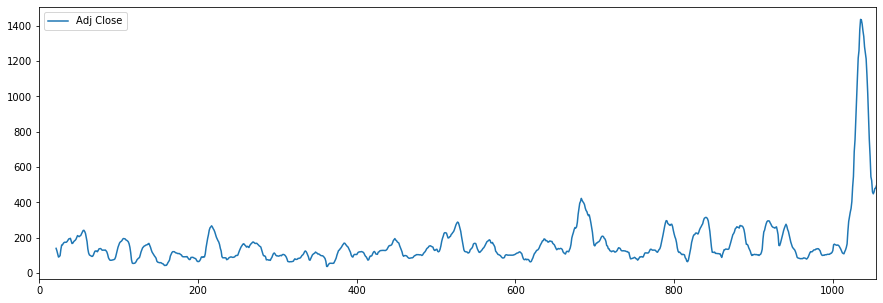

In [38]:
NSEI_roll_std.plot(figsize=(15,5))